<a href="https://colab.research.google.com/github/yumi-kim/big_data_class/blob/master/%EC%BD%94%EB%94%A96%EC%9D%BC%EC%B0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
! cd /content/gdrive/My\ Drive
! cd analysis/경상대/2019/8.\ 강의/
! cd 2019바이오빅데이터/2019바이오빅데이터\ 수업자료/

/bin/bash: line 0: cd: analysis/경상대/2019/8. 강의/: No such file or directory
/bin/bash: line 0: cd: 2019바이오빅데이터/2019바이오빅데이터 수업자료/: No such file or directory


In [0]:
cd /content/gdrive/My\ Drive
cd analysis/경상대/2019/8.\ 강의/
cd 2019바이오빅데이터/2019바이오빅데이터\ 수업자료/

/content/gdrive/My Drive


In [0]:
import pandas as pd

In [0]:
df = pd.read_pickle('./gt_food_23accesions.pkl')
# df = pd.read_csv('./gt_food_23accessions.csv')

In [0]:
df.shape

(413041, 23)

In [0]:
type(df)

pandas.core.frame.DataFrame

In [0]:
type(df.loc[0])

pandas.core.series.Series

In [0]:
import numpy as np
from collections import Counter
from itertools import combinations_with_replacement
from scipy.stats import chi2


def get_pvalue(locus):
  alleles = np.stack([list(x) for x in df.loc[locus].values]).ravel()
  dic_allele_count = dict(Counter(alleles))
  dic_allele_frq   = {x : y / sum(dic_allele_count.values()) for x,y in dic_allele_count.items()}
  # genotype freq --> genotype count estimate 
  dic_gt_frq = {}
  for allele1, allele2 in combinations_with_replacement(dic_allele_frq.keys(),2):
    if allele1 == allele2:
      gt_frq = dic_allele_frq[allele1] * dic_allele_frq[allele2]
    else : 
      gt_frq = dic_allele_frq[allele1] * dic_allele_frq[allele2] * 2
    gt = allele1 + allele2
    dic_gt_frq[gt] = gt_frq
  gt_count_est = np.array(list(dic_gt_frq.values())) * df.shape[1] # number of samples
  gt_count_obs = np.array([list(df.loc[locus]).count(x) for x in dic_gt_frq.keys()])
  # Chisqr test 
  chisqr = np.sum((gt_count_est - gt_count_obs) ** 2 / gt_count_est)
  pvalue = chi2.sf(chisqr,df=1)
  #print(pvalue)
  return pvalue

In [0]:
from tqdm import tqdm 
ps = []
for locus in tqdm(df.index):
  try:
    ps.append(get_pvalue(locus))
  except ValueError:
    ps.append(-99)

100%|██████████| 413041/413041 [08:11<00:00, 840.79it/s]


In [0]:
ps = np.array(ps)
ps_cor = ps[ps>0]

In [0]:
df_pvalue           = pd.DataFrame()
df_pvalue['Pvalue'] = ps
df_pvalue.to_pickle('./gt_food_23accesions.pvalue.pkl')

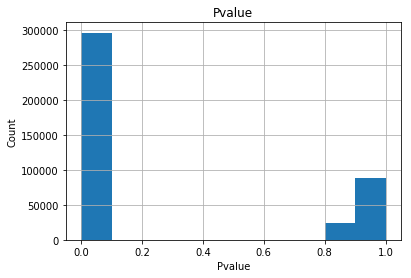

In [0]:
m = df_pvalue['Pvalue'] > 0
df_pvalue[m].hist()
plt.xlabel('Pvalue')
plt.ylabel('Count')
plt.show()

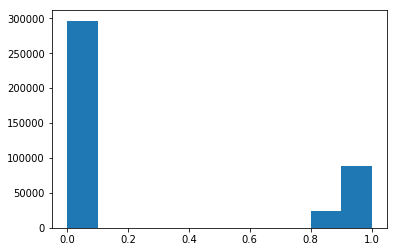

In [0]:
import matplotlib.pyplot as plt
plt.hist(ps_cor)
plt.show()

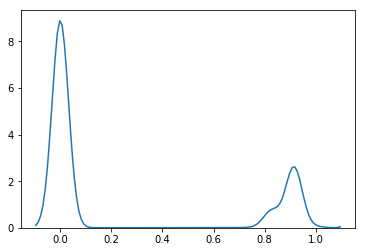

In [0]:
import seaborn as sb
sb.kdeplot(ps_cor)

In [0]:
# 하나의 로커스에 대한 pvalue를 구했습니다. 
# df.loc[0] 에서 시작함.
# 그렇다면
# 모든 로커스의 pvalue를 구해봅시다. 
